# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [1]:
import sys
print('Python executable:', sys.executable)
print('Python path:', sys.path[:3])

Python executable: c:\Users\anshu\anaconda3\envs\env_name\python.exe
Python path: ['c:\\Users\\anshu\\anaconda3\\envs\\env_name\\python310.zip', 'c:\\Users\\anshu\\anaconda3\\envs\\env_name\\DLLs', 'c:\\Users\\anshu\\anaconda3\\envs\\env_name\\lib']


## PyTorch Tensors

In [4]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([ 1.6909,  2.3956, -1.3460])
Addition: tensor([2.6909, 4.3956, 1.6540])
Mean: tensor(2.)


## Autograd Basics

In [5]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [6]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

## DataLoader

In [7]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 64, 64]) torch.Size([8, 1, 64, 64])


## Building a Simple CNN

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


## Training Loop Example

In [9]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [10]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


In [11]:
# 1) RandomMRIDataset -> return resized 128x128 slices using interpolation
import torch.nn.functional as F
class RandomMRIDataset128(Dataset):
    def __init__(self, length=200):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # generate a 64x64 fake MRI and mask then resize to 128x128
        image = torch.randn(1, 64, 64)
        mask = (torch.randn(1, 64, 64) > 0).float()
        # interpolate expects a batch dim -> add and remove it
        image = F.interpolate(image.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(128, 128), mode='nearest').squeeze(0)
        return image, mask

dataset128 = RandomMRIDataset128()
img128, msk128 = dataset128[0]
print('Resized image shape:', img128.shape, 'mask shape:', msk128.shape)

Resized image shape: torch.Size([1, 128, 128]) mask shape: torch.Size([1, 128, 128])


In [12]:
# 2) Add another convolution layer to SimpleCNN and compare parameter counts
def count_params(m):
    return sum(p.numel() for p in m.parameters())

class SimpleCNNOrig(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

class SimpleCNNAdded(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),  # extra conv
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# instantiate on a 128x128 input assumption (after two pools -> 32x32)
orig = SimpleCNNOrig()
added = SimpleCNNAdded()
print('Original SimpleCNN params:', count_params(orig))
print('SimpleCNN with extra conv params:', count_params(added))

Original SimpleCNN params: 37569
SimpleCNN with extra conv params: 39889


In [13]:
# 3) Mini U-Net implementation using conv_block
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = conv_block(1, 16)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = conv_block(16, 32)
        self.bottleneck = conv_block(32, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = conv_block(64, 32)
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = conv_block(32, 16)
        self.out_conv = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)
        b = self.bottleneck(p2)
        u2 = self.up2(b)
        cat2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(cat2)
        u1 = self.up1(d2)
        cat1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(cat1)
        out = self.out_conv(d1)
        return torch.sigmoid(out)

unet = MiniUNet()
print('MiniUNet parameter count:', sum(p.numel() for p in unet.parameters()))
# sanity forward pass
s = torch.randn(2, 1, 128, 128)
o = unet(s)
print('MiniUNet output shape:', o.shape)

MiniUNet parameter count: 116753
MiniUNet output shape: torch.Size([2, 1, 128, 128])


In [14]:
# 4) Dice Loss implementation
def dice_loss(preds, targets, eps=1e-6):
    # preds and targets are expected as floats in [0,1] and same shape
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1)
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()

# quick check
p = torch.rand(2, 1, 128, 128)
t = (torch.rand(2, 1, 128, 128) > 0.5).float()
print('Dice loss (random):', dice_loss(p, t).item())

Dice loss (random): 0.49542367458343506


Epoch 1/5 - Loss: 0.7156
Epoch 2/5 - Loss: 0.6973
Epoch 3/5 - Loss: 0.6932
Epoch 4/5 - Loss: 0.6931
Epoch 5/5 - Loss: 0.6930


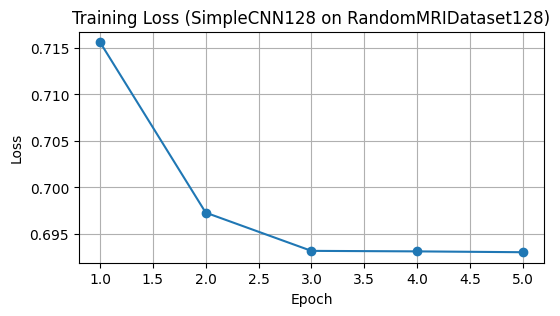

: 

In [ ]:
# 5) Train SimpleCNN-like model on the random 128x128 dataset and plot loss curve
class SimpleCNN128(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # after three pools: 128 -> 64 -> 32 -> 16
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# prepare data and training components
dl = DataLoader(dataset128, batch_size=8, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model128 = SimpleCNN128().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model128.parameters(), lr=1e-3)

num_epochs = 5
loss_history = []
for epoch in range(num_epochs):
    epoch_losses = []
    for images, masks in dl:
        images = images.to(device)
        masks = masks.to(device)
        # create a simple scalar target per image (mean of mask > 0.5) to match classifier output
        targets = (masks.view(masks.size(0), -1).mean(dim=1) > 0.5).float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        preds = model128(images)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    mean_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(mean_loss)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {mean_loss:.4f}')

# plot loss curve
plt.figure(figsize=(6,3))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (SimpleCNN128 on RandomMRIDataset128)')
plt.grid(True)
plt.show()